In [1]:
!nvidia-smi


Mon Jun 30 17:20:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#preprocess and mine the text data
import pandas as pd
import re
import string
!pip install pdfminer.six

from pdfminer.high_level import extract_text
!pip install -q sentence-transformers spacy
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 110.5 MB/s eta 0:00:00
✔ Download and installation successful
You ca

In [3]:
#compute similarity between resume and job role
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#from pdf
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)

#from docx
def extract_text_from_docx(docx_path):
    txt = docx2txt.process(docx_path)
    if txt:
        return txt.replace('\t',' ')
    return None

In [5]:
#extraction of name
#match  = re.search(r'(\b[A-Z][a-z]+\b)\s(\b[A-Z][a-z]+\b)', s)

def extract_name_from_resume(s):
    name = None
    pattern = r"(\b[A-Z][a-z]+\b)\s(\b[A-Z][a-z]+\b)"
    match = re.search(pattern,s)
    if match:
        name = match.group()
    return name






In [6]:
#Extraction of Phone number
#match = re.findall('''(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)[-\.\s]*\d{3}[-\.\s]??\d{4}|\d{5}[-\.\s]??\d{4})''',s)

def extract_contact_number_from_resume(s):
    contact_number = None
    pattern = r"(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)[-\.\s]*\d{3}[-\.\s]??\d{4}|\d{5}[-\.\s]??\d{4})"
    match = re.search(pattern, s)
    if match:
        contact_number = match.group()
    return contact_number

In [7]:
#Extraction of email
#match = re.findall(r'[\w\.-]+@[\w\.-]+',s)

def extract_email_from_resume(s):
    email = None
    pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
    match = re.search(pattern,s)
    if match:
        email = match.group()
    return email

In [8]:
#Extraction of Education
#match  = re.search(r"(?i)(?:Bsc|\bB\.\[A-Za-z]+|\bM\.\[A-Za-z]+|\bPh\.D\.\[A-Za-z]+|\bBachelor(?:'s)?|\bMaster(?:'s)?|\bPh\.D)\s(?:\w+\s)*\w+|B\.[A-Za-z]+", s)

def extract_education_from_resume(s):
    education = []
    pattern = r"(?i)(?:Bsc|\bM\.\[A-Za-z]+|\bPh\.D\.\[A-Za-z]+|\bBachelor(?:'s)?|\bBachelors(?:'s)?|\bMaster(?:'s)?|\bMasters(?:'s)?|\bPh\.D)\s(?:\w+\s)*\w+|B\.[A-Za-z]+"
    matches = re.findall(pattern, s)
    for match in matches:
        education.append(match.strip())
    return education

In [9]:
#Extraction of GPA
#match = re.findall([0-9]+\.\d?(\d))

def extract_gpa_from_resume(s):
    gpa = None
    pattern = r'[0-9]+\.\d?(\d)'
    match = re.search(pattern,s)
    if match:
        gpa = match.group()
    return gpa

In [10]:
#Extraction of Skills
def extract_skills_from_resume(s, skills_list):
    skills = []
    for skill in skills_list:
        pattern = r"\b{}\b".format(re.escape(skill))
        match = re.search(pattern, s, re.IGNORECASE)
        if match:
            skills.append(skill)
    return skills

In [11]:
#key: job role, values: skill requirements

jobRoles = {
    'Frontend Engineer': [
        'html', 'html5', 'css', 'css3', 'javascript', 'react', 'reactjs',
        'angular', 'angularjs', 'jquery', 'responsive design',
        'ui development', 'ux design', 'frontend development'
    ],
    'Backend Engineer': [
        'java', 'python', 'node.js', 'php', 'ruby', 'restful apis',
        'api development', 'server-side logic', 'authentication',
        'database management', 'sql', 'nosql', 'django', 'flask'
    ],
    'Fullstack Developer': [
        'html', 'css', 'javascript', 'react', 'angular', 'node.js',
        'python', 'java', 'php', 'restful apis', 'mongodb',
        'mysql', 'frontend development', 'backend development'
    ],
    'Software Engineer': [
        'java', 'python', 'c++', 'c#', 'data structures', 'algorithms',
        'object-oriented programming', 'system design', 'software development',
        'version control', 'git', 'debugging', 'unit testing', 'oop'
    ],
    'Cybersecurity Engineer': [
        'network security', 'firewall', 'penetration testing',
        'vulnerability assessment', 'ethical hacking',
        'digital forensics', 'incident response', 'siem', 'malware analysis'
    ],
    'Blockchain Engineer': [
        'blockchain', 'solidity', 'ethereum', 'smart contracts',
        'cryptography', 'consensus algorithms', 'web3', 'distributed ledger',
        'go', 'rust', 'blockchain architecture'
    ],
    'DevOps Engineer': [
        'docker', 'kubernetes', 'ci/cd', 'jenkins', 'ansible',
        'terraform', 'aws', 'azure', 'linux', 'monitoring', 'scripting'
    ],
    'Android Developer': [
        'android', 'android studio', 'java', 'kotlin', 'xml',
        'firebase', 'restful apis', 'material design', 'android sdk',
        'mobile app development'
    ],
    'Database Administrator': [
        'sql', 'oracle', 'mysql', 'postgresql', 'nosql', 'database tuning',
        'data backup', 'data recovery', 'performance monitoring',
        'database architecture'
    ],
    'Data Analyst': [
        'sql', 'python', 'r', 'excel', 'tableau', 'power bi',
        'data visualization', 'data cleaning', 'data wrangling',
        'statistical analysis', 'reporting'
    ],
    'Data Scientist': [
        'python', 'r', 'machine learning', 'deep learning',
        'scikit-learn', 'tensorflow', 'keras', 'nlp', 'pandas', 'matplotlib',
        'data preprocessing', 'model evaluation', 'predictive modeling'
    ],
    'Data Engineer': [
        'python', 'java', 'scala', 'spark', 'hadoop', 'etl',
        'airflow', 'kafka', 'data pipelines', 'bigquery', 'redshift',
        'data warehouse', 'data lakes'
    ],
    'Business Analyst': [
        'sql', 'excel', 'power bi', 'tableau', 'requirement gathering',
        'process modeling', 'use case analysis', 'gap analysis',
        'business intelligence', 'data analysis'
    ],
    'Machine Learning Engineer': [
        'python', 'machine learning', 'deep learning', 'tensorflow',
        'keras', 'pytorch', 'model deployment', 'scikit-learn',
        'model training', 'data preprocessing'
    ],
    'Electrical and Electronics Engineer': [
    'circuit design', 'power systems', 'electrical machines', 'pcb design',
    'signal processing', 'transformers', 'microcontrollers', 'multisim',
    'proteus', 'simulink', 'matlab', 'embedded systems', 'analog electronics',
    'digital electronics', 'sensors', 'arduino', 'oscilloscope', 'vhdl', 'verilog'
],
    'Embedded Engineer': [
    'embedded systems', 'microcontrollers', 'c programming', 'firmware development',
    'rtos', 'i2c', 'spi', 'uart', 'arm cortex', 'stm32', 'pic microcontroller',
    'interrupts', 'gpio', 'arduino', 'raspberry pi', 'real-time systems',
    'keil', 'proteus', 'assembly language', 'bare metal programming'
],


    'Artificial Intelligence Engineer': [
        'ai', 'python', 'r', 'c++', 'machine learning',
        'neural networks', 'computer vision', 'nlp',
        'tensorflow', 'keras', 'model optimization'
    ]
}

import ipywidgets as widgets
from IPython.display import display

# Create a dropdown to choose a job role
role_dropdown = widgets.Dropdown(
    options=list(jobRoles.keys()),
    description='Select Role:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)





In [12]:
#remove punctuation and stopwords

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

In [13]:
# Semantic and NLP models
from sentence_transformers import SentenceTransformer, util
import spacy

# Load pretrained models
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
nlp = spacy.load("en_core_web_sm")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
# Compute semantic similarity
def compute_semantic_similarity(text1, text2):
    embedding1 = semantic_model.encode(text1, convert_to_tensor=True)
    embedding2 = semantic_model.encode(text2, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embedding1, embedding2)
    return similarity.item()

# Extract named entities using spaCy
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import spacy
import re

# Load models
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
nlp = spacy.load("en_core_web_sm")

# Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

# TF-IDF similarity
def calculate_tfidf_similarity(text, keyword_list):
    text_str = ' '.join(text)
    keyword_str = ' '.join(keyword_list)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text_str, keyword_str])
    similarity = cosine_similarity(tfidf_matrix)[0, 1]
    return similarity

# Semantic similarity
def calculate_semantic_similarity(text, keyword_list):
    text_str = ' '.join(text)
    keyword_str = ' '.join(keyword_list)

    embedding_text = semantic_model.encode(text_str, convert_to_tensor=True)
    embedding_keywords = semantic_model.encode(keyword_str, convert_to_tensor=True)

    similarity = util.pytorch_cos_sim(embedding_text, embedding_keywords)
    return similarity.item()

# Combined similarity
def calculate_combined_similarity(text, keyword_list, tfidf_weight=0.3, semantic_weight=0.7):
    tfidf_score = calculate_tfidf_similarity(text, keyword_list)
    semantic_score = calculate_semantic_similarity(text, keyword_list)
    combined_score = tfidf_weight * tfidf_score + semantic_weight * semantic_score
    return combined_score

# Updated match function: processes full keyword list per job role as one string
# def calculate_keyword_match(text, keywords):
#     text_tokens = preprocess_text(text)
#     keyword_match = {}

#     print("\n📊 Combined Similarity Scores for Each Job Role:\n")

#     for role, keyword_list in keywords.items():
#         # Join all keywords for the role as one combined context
#         combined_keywords = ' '.join(preprocess_text(' '.join(keyword_list)))
#         score = calculate_combined_similarity(text_tokens, combined_keywords.split())
#         keyword_match[role] = score

#         # Print score
#         print(f"{role}: {score:.4f}")

#     # Top 3 roles
#     top_roles = sorted(keyword_match, key=keyword_match.get, reverse=True)[:3]

#     print("\n🎯 Top 3 Predicted Roles:")
#     for r in top_roles:
#         print("✅", r)

#     return top_roles

# yaha se new he

# def get_matched_keywords(resume_tokens, keyword_list):
#     resume_set = set(resume_tokens)
#     return [kw.lower() for kw in keyword_list if kw.lower() in resume_set]


# def calculate_keyword_match(text, keywords, return_explanation=False):
#     text_tokens = preprocess_text(text)
#     keyword_match = {}
#     match_details = {}

#     print("\n📊 Combined Similarity Scores for Each Job Role:\n")

#     for role, keyword_list in keywords.items():
#         combined_keywords = ' '.join(preprocess_text(' '.join(keyword_list)))
#         combined_tokens = combined_keywords.split()

#         # Similarity score
#         score = calculate_combined_similarity(text_tokens, combined_tokens)
#         keyword_match[role] = score

#         # Matched keywords
#         matched = get_matched_keywords(text_tokens, keyword_list)
#         match_details[role] = {
#             "score": score,
#             "matched_keywords": matched,
#             "match_count": len(matched)
#         }

#         # Print role-level details
#         print(f"{role}: {score:.4f} | Matched: {len(matched)} keywords")

#     # Top 3 roles
#     top_roles = sorted(keyword_match, key=keyword_match.get, reverse=True)[:3]

#     print("\n🎯 Top 3 Predicted Roles:")
#     for r in top_roles:
#         print(f"✅ {r} (Score: {keyword_match[r]:.4f})")
#         if return_explanation:
#             print(f"   🧠 Matched Keywords ({match_details[r]['match_count']}): {', '.join(match_details[r]['matched_keywords'])}")

#     if return_explanation:
#         return top_roles, {k: match_details[k] for k in top_roles}

#     return top_roles



In [16]:
def get_matched_keywords(resume_tokens, keyword_list):
    resume_set = set(resume_tokens)
    return [kw.lower() for kw in keyword_list if kw.lower() in resume_set]

def get_missing_skills(resume_tokens, keyword_list):
    resume_set = set(resume_tokens)
    expected_skills = set([kw.lower() for kw in keyword_list])
    return list(expected_skills - resume_set)

# 🧠 Optional: Skill → Course mapping dictionary
skill_course_map = {
    "python": ["🔗 https://www.coursera.org/specializations/python"],
"c": ["🔗 https://www.udemy.com/course/c-programming-for-beginners/"],
"c++": ["🔗 https://www.udemy.com/course/beginning-c-plus-plus-programming/"],
"java": ["🔗 https://www.coursera.org/learn/java-programming"],
"javascript": ["🔗 https://www.freecodecamp.org/learn/javascript-algorithms-and-data-structures/"],
"html": ["🔗 https://www.freecodecamp.org/learn/responsive-web-design/"],
"css": ["🔗 https://www.freecodecamp.org/learn/responsive-web-design/"],
"sql": ["🔗 https://www.coursera.org/learn/sql-for-data-science"],
"r": ["🔗 https://www.datacamp.com/courses/free-introduction-to-r"],
"react": ["🔗 https://www.udemy.com/course/react-the-complete-guide-incl-redux/"],
"node.js": ["🔗 https://www.coursera.org/projects/create-a-backend-app-with-javascript"],
"pandas": ["🔗 https://www.youtube.com/watch?v=r-uOLxNrNk8"],
"numpy": ["🔗 https://www.w3schools.com/python/numpy/"],
"matplotlib": ["🔗 https://www.youtube.com/watch?v=3Xc3CA655Y4"],
"scikit learn": ["🔗 https://www.datacamp.com/courses/supervised-learning-with-scikit-learn"],
"tensorflow": ["🔗 https://www.coursera.org/professional-certificates/tensorflow-in-practice"],
"keras": ["🔗 https://keras.io/getting_started/"],
"machine learning": ["🔗 https://www.coursera.org/learn/machine-learning"],
"deep learning": ["🔗 https://www.coursera.org/specializations/deep-learning"],
"data visualization": ["🔗 https://www.coursera.org/learn/python-for-data-visualization"],
"power bi": ["🔗 https://www.udemy.com/course/microsoft-power-bi-up-running-with-power-bi-desktop/"],
"mysql": ["🔗 https://www.coursera.org/learn/database-management"],
"mongodb": ["🔗 https://www.udemy.com/course/mongodb-the-complete-developers-guide/"],
"postgresql": ["🔗 https://www.udemy.com/course/sql-and-postgresql/"],
"firebase": ["🔗 https://www.coursera.org/projects/build-a-firebase-web-app"],
"aws": ["🔗 https://www.coursera.org/specializations/aws-fundamentals"],
"google cloud": ["🔗 https://www.coursera.org/professional-certificates/cloud-engineering-gcp"],
"azure": ["🔗 https://learn.microsoft.com/en-us/training/azure/"],
"docker": ["🔗 https://www.coursera.org/learn/docker"],
"kubernetes": ["🔗 https://www.udemy.com/course/learn-kubernetes/"],
"arduino": ["🔗 https://www.youtube.com/watch?v=1AXJne5U3aI"],
"plc": ["🔗 https://www.udemy.com/course/plc-programming-from-scratch/"],
"multisim": ["🔗 https://www.youtube.com/watch?v=WYBrdFe69mA"],
"matlab": ["🔗 https://matlabacademy.mathworks.com/details/matlab-onramp/getting-started"],
"simulink": ["🔗 https://matlabacademy.mathworks.com/details/simulink-onramp/getting-started"],
"rtos": ["🔗 https://www.udemy.com/course/rtos/"],
"microcontroller": ["🔗 https://www.edx.org/course/embedded-systems-shape-the-world"],
"uart": ["🔗 https://www.youtube.com/watch?v=0zzTzZHXJLg"],
"i2c": ["🔗 https://www.youtube.com/watch?v=HuyQmpDx0fM"],
"spi": ["🔗 https://www.youtube.com/watch?v=ZfQv5H9Z3jw"],
"power systems": ["🔗 https://nptel.ac.in/courses/108/105/108105067/"],
"electrical machines": ["🔗 https://nptel.ac.in/courses/108/105/108105017/"],
"transformers": ["🔗 https://www.youtube.com/playlist?list=PLBlnK6fEyqRj0jkK4FQSOX3aZrS0mT1qg"],
"communication": ["🔗 https://www.coursera.org/learn/wharton-communication-skills"],
"teamwork": ["🔗 https://www.edx.org/learn/communication"],
"problem solving": ["🔗 https://www.coursera.org/learn/creative-problem-solving"],
"project management": ["🔗 https://www.coursera.org/specializations/project-management"],
"git": ["🔗 https://www.youtube.com/watch?v=RGOj5yH7evk"],
"github": ["🔗 https://www.udemy.com/course/git-and-github-bootcamp/"],
"ci/cd": ["🔗 https://www.coursera.org/learn/devops-cicd"],
"linux": ["🔗 https://www.udemy.com/course/linux-for-beginners/"],
}


def calculate_keyword_match(text, keywords, return_explanation=False):
    text_tokens = preprocess_text(text)
    keyword_match = {}
    match_details = {}

    print("\n📊 Combined Similarity Scores for Each Job Role:\n")

    for role, keyword_list in keywords.items():
        combined_keywords = ' '.join(preprocess_text(' '.join(keyword_list)))
        combined_tokens = combined_keywords.split()

        # Similarity score
        score = calculate_combined_similarity(text_tokens, combined_tokens)
        keyword_match[role] = score

        # Matched + Missing + Courses
        matched = get_matched_keywords(text_tokens, keyword_list)
        missing = get_missing_skills(text_tokens, keyword_list)
        courses = [course for skill in missing if skill in skill_course_map for course in skill_course_map[skill]]

        match_details[role] = {
            "score": score,
            "matched_keywords": matched,
            "missing_keywords": missing,
            "courses": courses,
            "match_count": len(matched)
        }

        print(f"{role}: {score:.4f} | Matched: {len(matched)} keywords")

    # Top 3 roles
    top_roles = sorted(keyword_match, key=keyword_match.get, reverse=True)[:3]

    print("\n🎯 Top 3 Predicted Roles:")
    for r in top_roles:
        print(f"\n {r} (Score: {keyword_match[r]:.4f})")
        print(f"    Matched Keywords ({match_details[r]['match_count']}): {', '.join(match_details[r]['matched_keywords'])}")
        print(f"   Missing Skills: {', '.join(match_details[r]['missing_keywords']) if match_details[r]['missing_keywords'] else 'None'}")

        if match_details[r]['courses']:
            print("   🎓 Recommended Courses:")
            for c in match_details[r]['courses']:
                print(f"     - {c}")
        else:
            print("   No course needed — strong match!")

    if return_explanation:
        return top_roles, {k: match_details[k] for k in top_roles}

    return top_roles


In [17]:
resume_text = """
electrical engineer with experience in semiconductors. also capable of doing SQL and power bi along ml and dl . i have profienet in nlp as will. doing projects in robotics also
"""

top_roles = calculate_keyword_match(resume_text, jobRoles)
top_roles, explanation = calculate_keyword_match(resume_text, jobRoles, return_explanation=True)
top_roles, explanation = calculate_keyword_match(resume_text, jobRoles, return_explanation=True)





📊 Combined Similarity Scores for Each Job Role:

Frontend Engineer: 0.0645 | Matched: 0 keywords
Backend Engineer: 0.0854 | Matched: 1 keywords
Fullstack Developer: 0.0708 | Matched: 0 keywords
Software Engineer: 0.0821 | Matched: 0 keywords
Cybersecurity Engineer: 0.0657 | Matched: 0 keywords
Blockchain Engineer: 0.0477 | Matched: 0 keywords
DevOps Engineer: -0.0032 | Matched: 0 keywords
Android Developer: 0.0531 | Matched: 0 keywords
Database Administrator: 0.0482 | Matched: 1 keywords
Data Analyst: 0.1464 | Matched: 1 keywords
Data Scientist: 0.1123 | Matched: 1 keywords
Data Engineer: 0.1104 | Matched: 0 keywords
Business Analyst: 0.2350 | Matched: 1 keywords
Machine Learning Engineer: 0.0837 | Matched: 0 keywords
Electrical and Electronics Engineer: 0.2358 | Matched: 0 keywords
Embedded Engineer: 0.1186 | Matched: 0 keywords
Artificial Intelligence Engineer: 0.1375 | Matched: 1 keywords

🎯 Top 3 Predicted Roles:

✅ Electrical and Electronics Engineer (Score: 0.2358)
   🧠 Matched 

In [18]:
from pdfminer.high_level import extract_text
from IPython.display import display
import ipywidgets as widgets

# Upload PDF file
upload = widgets.FileUpload(accept='.pdf', multiple=False)
display(upload)


FileUpload(value={}, accept='.pdf', description='Upload')

In [19]:
import io

def get_resume_text_from_pdf(upload_widget):
    if not upload_widget.value:
        print("No file uploaded.")
        return None

    uploaded_file = list(upload_widget.value.values())[0]
    pdf_bytes = io.BytesIO(uploaded_file['content'])

    try:
        extracted_text = extract_text(pdf_bytes)
        print("Text extracted successfully.")
        return extracted_text
    except Exception as e:
        print("Error extracting text:", str(e))
        return None


In [20]:
# Extract and match roles
resume_text = get_resume_text_from_pdf(upload)
if resume_text:
    print("\n Extracted Resume Text (first 500 chars):\n")
    print(resume_text[:500])  # preview
    print("\n Matching Job Roles:\n")
    top_roles = calculate_keyword_match(resume_text, jobRoles)
    top_roles, explanation = calculate_keyword_match(resume_text, jobRoles, return_explanation=True)


Text extracted successfully.

 Extracted Resume Text (first 500 chars):

Akshat Agarwal

§ GitHub | (cid:239) LinkedIn | # akshat.aga011@gmail.com | H 7976355568

Education

2022 – Present
2021
2019
Work Experience

B.Tech (Electrical), MANIT-Bhopal (NIT-B)
Class 12th CBSE
Class 10th CBSE

(CGPA: 9.06/10)
(Percentage: 95.6)
(Percentage: 94.8)

Summer Training at Sangam India Pvt Ltd Bhilwara (Rajasthan)
May 2024 – June 2024
• Collaborated with a team of 5+ engineers in monitoring, testing, and maintainin different types of electrical automation

components used acros

 Matching Job Roles:


📊 Combined Similarity Scores for Each Job Role:

Frontend Engineer: 0.0205 | Matched: 1 keywords
Backend Engineer: 0.0504 | Matched: 2 keywords
Fullstack Developer: -0.0348 | Matched: 2 keywords
Software Engineer: 0.1176 | Matched: 1 keywords
Cybersecurity Engineer: 0.0943 | Matched: 0 keywords
Blockchain Engineer: 0.0512 | Matched: 0 keywords
DevOps Engineer: 0.1697 | Matched: 1 keywords
Android De

In [31]:
from IPython.display import display
import ipywidgets as widgets

# Upload multiple PDFs
upload_multi = widgets.FileUpload(accept='.pdf', multiple=True)
display(upload_multi)




FileUpload(value={}, accept='.pdf', description='Upload', multiple=True)

In [32]:
# Check how many files were uploaded
print("Uploaded file names:")
for file_name in upload_multi.value.keys():
    print("📄", file_name)

print(f"\n✅ Total uploaded PDFs: {len(upload_multi.value)}")

Uploaded file names:
📄 harsh jain resume.pdf
📄 Core_resume.pdf
📄 sweksha tech.pdf
📄 sweksha resume.pdf
📄 Akshat_CV_Leap.pdf

✅ Total uploaded PDFs: 5


In [33]:
import io
from pdfminer.high_level import extract_text

def match_resumes_for_role(upload_widget, target_role, jobRolesDict):
    if not upload_widget.value:
        print("❌ No files uploaded.")
        return

    if target_role not in jobRolesDict:
        print("❌ Role not found in jobRoles dictionary.")
        return

    role_keywords = ' '.join(preprocess_text(' '.join(jobRolesDict[target_role])))
    ranking = {}

    for name, file in upload_widget.value.items():
        pdf_bytes = io.BytesIO(file['content'])
        resume_text = extract_text(pdf_bytes)
        text_tokens = preprocess_text(resume_text)

        score = calculate_combined_similarity(text_tokens, role_keywords.split())
        ranking[name] = score

    # Sort by similarity score
    ranked = sorted(ranking.items(), key=lambda x: x[1], reverse=True)

    print(f"\n📋 Ranked Resumes for Role: {target_role}\n")
    for i, (name, score) in enumerate(ranked, 1):
        print(f"{i}. {name} — Score: {score:.4f}")

    return ranked


In [34]:

display(role_dropdown)




Dropdown(description='Select Role:', index=14, layout=Layout(width='50%'), options=('Frontend Engineer', 'Back…

In [35]:
match_resumes_for_role(upload_multi,role_dropdown.value, jobRoles)


📋 Ranked Resumes for Role: Electrical and Electronics Engineer

1. sweksha resume.pdf — Score: 0.2546
2. Core_resume.pdf — Score: 0.2325
3. Akshat_CV_Leap.pdf — Score: 0.1923
4. harsh jain resume.pdf — Score: 0.1168
5. sweksha tech.pdf — Score: 0.1154


[('sweksha resume.pdf', np.float64(0.25464742834148624)),
 ('Core_resume.pdf', np.float64(0.23245657914524542)),
 ('Akshat_CV_Leap.pdf', np.float64(0.19232947966477937)),
 ('harsh jain resume.pdf', np.float64(0.11684664338827132)),
 ('sweksha tech.pdf', np.float64(0.11539479862791034))]

In [36]:
list(upload_multi.value.keys())


['harsh jain resume.pdf',
 'Core_resume.pdf',
 'sweksha tech.pdf',
 'sweksha resume.pdf',
 'Akshat_CV_Leap.pdf']

In [44]:
evaluation_data = [
    {"filename": "harsh jain resume.pdf", "true_role": "Data Scientist"},
    {"filename": "Core_resume.pdf", "true_role": "Electrical and Electronics Engineer"},
    {"filename": "sweksha tech.pdf", "true_role": "Fullstack Developer"},
    {"filename": "sweksha resume.pdf", "true_role": "Electrical and Electronics Engineer"},
    {"filename": "Akshat_CV_Leap.pdf", "true_role": "Machine Learning Engineer"},

]


In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [40]:
def evaluate_matching_system(evaluation_data, upload_widget, jobRolesDict):
    correct_top1 = 0
    correct_top3 = 0
    total = len(evaluation_data)

    results = []  # store results per resume

    for entry in evaluation_data:
        file_name = entry['filename']
        true_role = entry['true_role']

        if file_name not in upload_widget.value:
            print(f"⚠️ {file_name} not found in uploaded files.")
            continue

        file = upload_widget.value[file_name]
        resume_text = extract_text(io.BytesIO(file['content']))
        text_tokens = preprocess_text(resume_text)

        role_scores = {}
        for role, keywords in jobRolesDict.items():
            score = calculate_combined_similarity(text_tokens, [kw for kw in preprocess_text(' '.join(keywords))])
            role_scores[role] = score

        top3_roles = sorted(role_scores, key=role_scores.get, reverse=True)[:3]
        top1_role = top3_roles[0]

        if top1_role == true_role:
            correct_top1 += 1
        if true_role in top3_roles:
            correct_top3 += 1

        print(f"\n📄 {file_name}")
        print(f"✅ True Role: {true_role}")
        print(f"🎯 Top 3 Predicted Roles: {top3_roles}")

        results.append({
            "Resume": file_name,
            "True Role": true_role,
            "Top Prediction": top1_role,
            "Top 3 Predictions": ', '.join(top3_roles)
        })

    print("\n📊 Evaluation Results:")
    print(f"Top-1 Accuracy: {correct_top1}/{total} = {correct_top1/total:.2f}")
    print(f"Top-3 Accuracy: {correct_top3}/{total} = {correct_top3/total:.2f}")

    return results






In [45]:
results = evaluate_matching_system(evaluation_data, upload_multi, jobRoles)
# results are for  above code
#results_df for barcharts below


📄 harsh jain resume.pdf
✅ True Role: Data Scientist
🎯 Top 3 Predicted Roles: ['Data Scientist', 'Machine Learning Engineer', 'Cybersecurity Engineer']

📄 Core_resume.pdf
✅ True Role: Electrical and Electronics Engineer
🎯 Top 3 Predicted Roles: ['Electrical and Electronics Engineer', 'Machine Learning Engineer', 'Embedded Engineer']

📄 sweksha tech.pdf
✅ True Role: Fullstack Developer
🎯 Top 3 Predicted Roles: ['Backend Engineer', 'Fullstack Developer', 'Blockchain Engineer']

📄 sweksha resume.pdf
✅ True Role: Electrical and Electronics Engineer
🎯 Top 3 Predicted Roles: ['Electrical and Electronics Engineer', 'Embedded Engineer', 'Cybersecurity Engineer']

📄 Akshat_CV_Leap.pdf
✅ True Role: Machine Learning Engineer
🎯 Top 3 Predicted Roles: ['Machine Learning Engineer', 'Artificial Intelligence Engineer', 'Electrical and Electronics Engineer']

📊 Evaluation Results:
Top-1 Accuracy: 4/5 = 0.80
Top-3 Accuracy: 5/5 = 1.00


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Extract true and predicted labels
y_true = [r['True Role'] for r in results]
y_pred = [r['Top Prediction'] for r in results]

print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, zero_division=0))





📋 Classification Report:

                                     precision    recall  f1-score   support

                   Backend Engineer       0.00      0.00      0.00         0
                     Data Scientist       1.00      1.00      1.00         1
Electrical and Electronics Engineer       1.00      1.00      1.00         2
                Fullstack Developer       0.00      0.00      0.00         1
          Machine Learning Engineer       1.00      1.00      1.00         1

                           accuracy                           0.80         5
                          macro avg       0.60      0.60      0.60         5
                       weighted avg       0.80      0.80      0.80         5



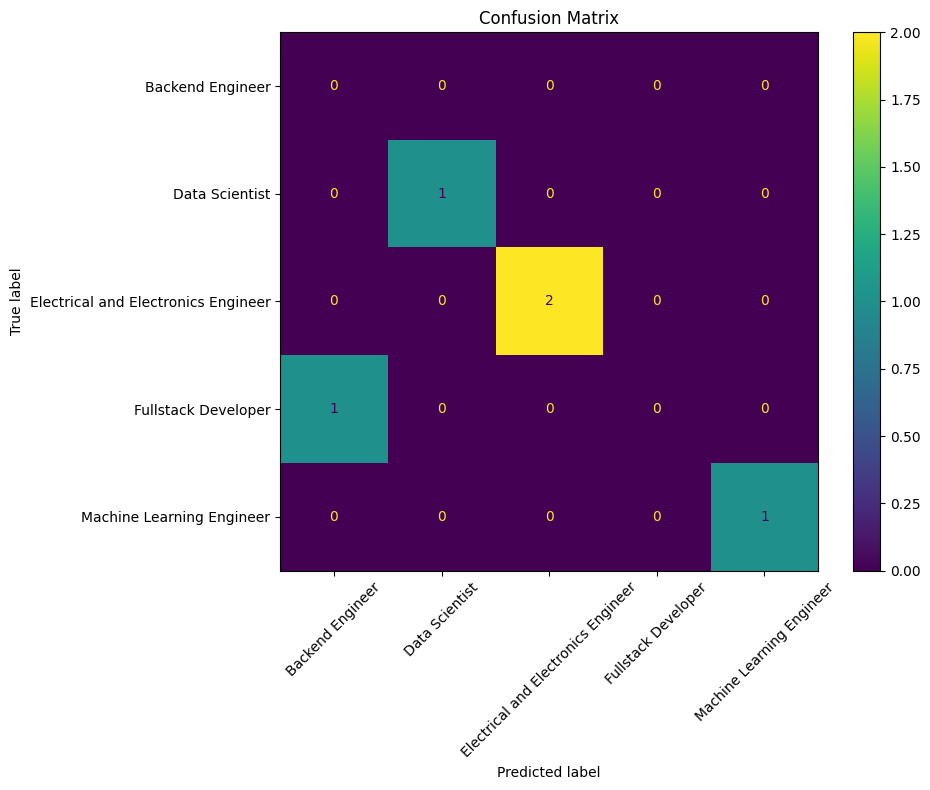

In [47]:
import matplotlib.pyplot as plt

labels = sorted(list(set(y_true + y_pred)))  # all unique role labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



In [52]:
# Access the file content from the upload_multi widget
res_filename = "Core_resume.pdf"

if res_filename in upload_multi.value:
    uploaded_file_info = upload_multi.value[res_filename]
    pdf_bytes = io.BytesIO(uploaded_file_info['content'])
    s1 = extract_text_from_pdf(pdf_bytes)

    print(s1)

    print("Name:", extract_name_from_resume(s1))
    print("Contact Number:", extract_contact_number_from_resume(s1))
    print("Email:", extract_email_from_resume(s1))
    print("Education:", extract_education_from_resume(s1))
    print("CGPA:", extract_gpa_from_resume(s1))
else:
    print(f"Error: {res_filename} not found in uploaded files.")

Akshat Agarwal

§ GitHub | (cid:239) LinkedIn | # akshat.aga011@gmail.com | H 7976355568

Education

2022 – Present
2021
2019
Work Experience

B.Tech (Electrical), MANIT-Bhopal (NIT-B)
Class 12th CBSE
Class 10th CBSE

(CGPA: 9.06/10)
(Percentage: 95.6)
(Percentage: 94.8)

Summer Training at Sangam India Pvt Ltd Bhilwara (Rajasthan)
May 2024 – June 2024
• Collaborated with a team of 5+ engineers in monitoring, testing, and maintainin different types of electrical automation

components used across multiple stages of manufacturing.

Training and Placement Cell, NIT Bhopal
May 2023 – April 2024
• Managed outreach for 100+ recruiting companies using tools like Mr.E and SignalHire, and supported the coordination of

10+ placement sessions and pre-placement talks that engaged over 800 students during the annual recruitment cycle.

Projects

KASHYAP: AI-Driven 5G-Enabled Autonomous Seed Sowing Robot (Ideation Stage)
March 2025 – Present
• Conceptualized a precision agriculture rover capable o